<a href="https://colab.research.google.com/github/IAMPathak2702/Food-vision-milestone-project/blob/main/Food360.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import keras
from keras import layers,Sequential,preprocessing
from keras.layers import Flatten , Dense , Conv2D , MaxPool2D

import os
import random
import pathlib

In [ ]:
!chmod 600 /content/kaggle.json
os.environ["KAGGLE_CONFIG_DIR"] = '/content'

In [ ]:
!kaggle datasets download -d moltean/fruits

100% 1.28G/1.28G [00:13<00:00, 81.8MB/s]
100% 1.28G/1.28G [00:13<00:00, 104MB/s] 


In [ ]:
!unzip -q \*.zip

In [ ]:
for dirpath, dirnames, filenames in os.walk("/content/fruits-360_dataset"):

  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 1 directories and 0 images in '/content/fruits-360_dataset'.
There are 4 directories and 2 images in '/content/fruits-360_dataset/fruits-360'.
There are 0 directories and 103 images in '/content/fruits-360_dataset/fruits-360/test-multiple_fruits'.
There are 0 directories and 1 images in '/content/fruits-360_dataset/fruits-360/papers'.
There are 131 directories and 0 images in '/content/fruits-360_dataset/fruits-360/Training'.
There are 0 directories and 453 images in '/content/fruits-360_dataset/fruits-360/Training/Potato Red Washed'.
There are 0 directories and 711 images in '/content/fruits-360_dataset/fruits-360/Training/Pear Stone'.
There are 0 directories and 300 images in '/content/fruits-360_dataset/fruits-360/Training/Pear Kaiser'.
There are 0 directories and 738 images in '/content/fruits-360_dataset/fruits-360/Training/Cherry 2'.
There are 0 directories and 492 images in '/content/fruits-360_dataset/fruits-360/Training/Apricot'.
There are 0 directories and 490 image

In [ ]:
train_dir = "/content/fruits-360-original-size/fruits-360-original-size/Training/"
val_dir = "/content/fruits-360-original-size/fruits-360-original-size/Validation/"

In [ ]:
data_augmentation_layer = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),  # Rescale pixel values
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),  # Randomly flip images horizontally and vertically
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),  # Randomly rotate images up to 20 degrees
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),  # Randomly zoom images up to 20%
],name = "Data_Augumentation_layer")


In [ ]:
train_data = keras.utils.image_dataset_from_directory(
    directory=train_dir,
    label_mode = "categorical",
    image_size = (224,224),
    seed = 42,

)

val_data = keras.utils.image_dataset_from_directory(
    directory=val_dir,
    label_mode = "categorical",
    image_size = (224,224),
    seed = 42,

)


Found 6231 files belonging to 24 classes.
Found 3114 files belonging to 24 classes.


In [ ]:
class_names =train_data.class_names
class_names

['apple_6',
 'apple_braeburn_1',
 'apple_crimson_snow_1',
 'apple_golden_1',
 'apple_golden_2',
 'apple_golden_3',
 'apple_granny_smith_1',
 'apple_hit_1',
 'apple_pink_lady_1',
 'apple_red_1',
 'apple_red_2',
 'apple_red_3',
 'apple_red_delicios_1',
 'apple_red_yellow_1',
 'apple_rotten_1',
 'cabbage_white_1',
 'carrot_1',
 'cucumber_1',
 'cucumber_3',
 'eggplant_violet_1',
 'pear_1',
 'pear_3',
 'zucchini_1',
 'zucchini_dark_1']

In [ ]:
train_ds = train_data.prefetch(tf.data.AUTOTUNE)
val_ds = val_data.prefetch(tf.data.AUTOTUNE)

In [ ]:
train_ds , val_ds

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24), dtype=tf.float32, name=None))>)

In [ ]:
def view_random_image(target_dir,class_names):
    # Setup target directory (we'll view images from here)

    plt.figure(figsize = (20,14))
    for i in range(0,12):
        target_class = random.choice(list(class_names))
        target_folder = target_dir+target_class
        # Get a random image path
        random_image = random.sample(os.listdir(target_folder), 1)
        # Read in the image and plot it using matplotlib

        img = mpimg.imread(target_folder + "/" + random_image[0])
        ax = plt.subplot(3,4,i+1)
        plt.imshow(img)
        plt.title(f"{target_class}--{img.shape}")
        plt.axis("off");
    return img

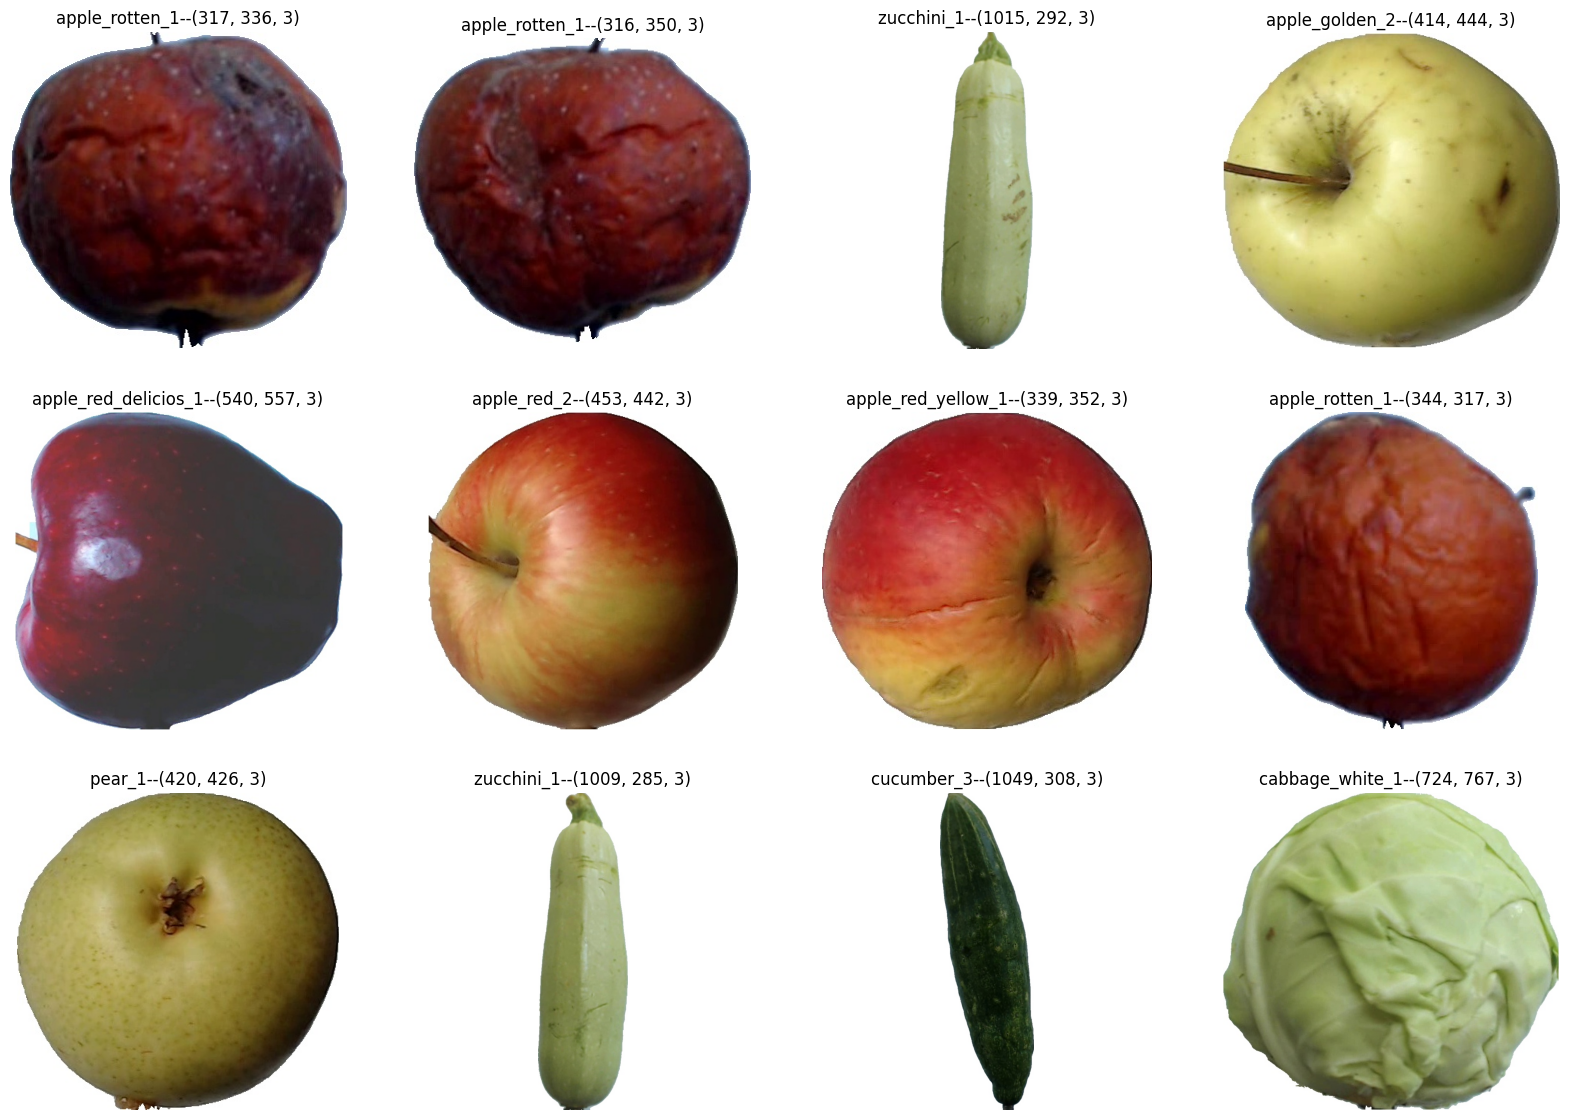

In [ ]:
img = view_random_image(target_dir=train_dir,
                        class_names = class_names)

In [ ]:
def model_checkpoint_callback(filepath):
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=f'/content/{filepath}',  # Specify the path to save the best model
        monitor='val_accuracy',   # Choose a metric to monitor (e.g., validation accuracy)
        save_best_only=True,       # Save only the best model
        save_weights_only=False,   # Set to True if you want to save only model weights
        mode='max',               # Set to 'max' for accuracy, 'min' for loss, or 'auto'
        verbose=0,               # Optional: Set to 1 for progress messages
    )
    return model_checkpoint_callback

In [ ]:

early_stopping = keras.callbacks.EarlyStopping(
                                                monitor='val_loss',   # Metric to monitor (e.g., 'val_loss' or 'val_accuracy')
                                                patience=3,           # Number of epochs with no improvement before stopping
                                                restore_best_weights=True  # Restore model weights from the best epoch
                                            )


In [ ]:
from keras.applications import VGG16
vgg = VGG16(input_shape = (224,224,3), include_top = False)
for layers in vgg.layers:
    layers.trainable = False
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
x = Flatten()(vgg.output)
o = Dense(len(class_names), activation="softmax", name="output_layer")(x)

model_0 = keras.Model(vgg.input,o)
model_0.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
model_0.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
hist_0 = model_0.fit(train_ds,
                        epochs = 5,
                        validation_data = val_ds,
                        callbacks = [model_checkpoint_callback('VGG16_Model'),early_stopping])

Epoch 1/5
195/195 [==============================] - 80s 405ms/step - loss: 0.0242 - accuracy: 0.9987 - val_loss: 0.0031 - val_accuracy: 0.9997
Epoch 2/5
195/195 [==============================] - 83s 422ms/step - loss: 5.8677e-04 - accuracy: 0.9998 - val_loss: 6.1251e-10 - val_accuracy: 1.0000
Epoch 3/5
195/195 [==============================] - 84s 429ms/step - loss: 3.4951e-08 - accuracy: 1.0000 - val_loss: 5.7423e-10 - val_accuracy: 1.0000
Epoch 4/5
195/195 [==============================] - 76s 379ms/step - loss: 2.5922e-08 - accuracy: 1.0000 - val_loss: 5.7423e-10 - val_accuracy: 1.0000
Epoch 5/5
195/195 [==============================] - 78s 396ms/step - loss: 2.0164e-08 - accuracy: 1.0000 - val_loss: 5.3594e-10 - val_accuracy: 1.0000


In [ ]:
model_0.evaluate(val_ds)

98/98 [==============================] - 29s 296ms/step - loss: 5.3594e-10 - accuracy: 1.0000


[5.359436783258786e-10, 1.0]

In [ ]:
model_0.save("VGG16")

In [ ]:
import matplotlib.pyplot as plt

def plot_hist_graph(history):
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title("Epoch vs Accuracy")

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.subplot(1, 3, 2)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 3, 3)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.show()


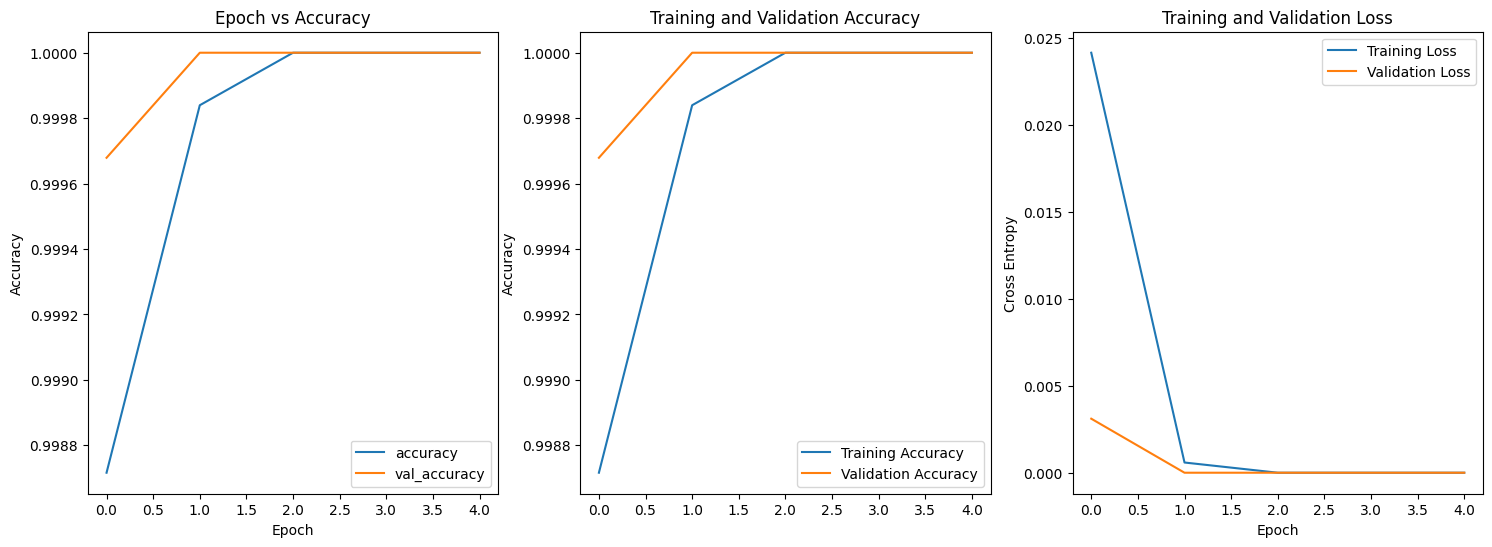

In [ ]:
plot_hist_graph(hist_0)

In [ ]:
from keras.applications import ResNet50

resnet = ResNet50(input_shape = (224,224,3) , include_top = False)
for layer in resnet.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(resnet.output)
o = Dense(len(class_names), activation="softmax", name="output_layer")(x)

model_1 = keras.Model(resnet.input ,o, name = "RESNET_MODEL")
model_1.summary()

Model: "RESNET_MODEL"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_9[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                   

In [ ]:
model_1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
hist_1 = model_1.fit(train_ds,
                        epochs = 3,
                        steps_per_epoch = len(train_ds),
                        validation_data = val_ds,
                        validation_steps = len(val_ds),
                        callbacks = [model_checkpoint_callback('MOdel_RESNET50'),early_stopping])

Epoch 1/3
195/195 [==============================] - 70s 336ms/step - loss: 0.8696 - accuracy: 0.9519 - val_loss: 0.0248 - val_accuracy: 0.9958
Epoch 2/3
195/195 [==============================] - 67s 342ms/step - loss: 0.0028 - accuracy: 0.9998 - val_loss: 1.6375e-07 - val_accuracy: 1.0000
Epoch 3/3
195/195 [==============================] - 50s 257ms/step - loss: 1.9648e-07 - accuracy: 1.0000 - val_loss: 6.8829e-08 - val_accuracy: 1.0000


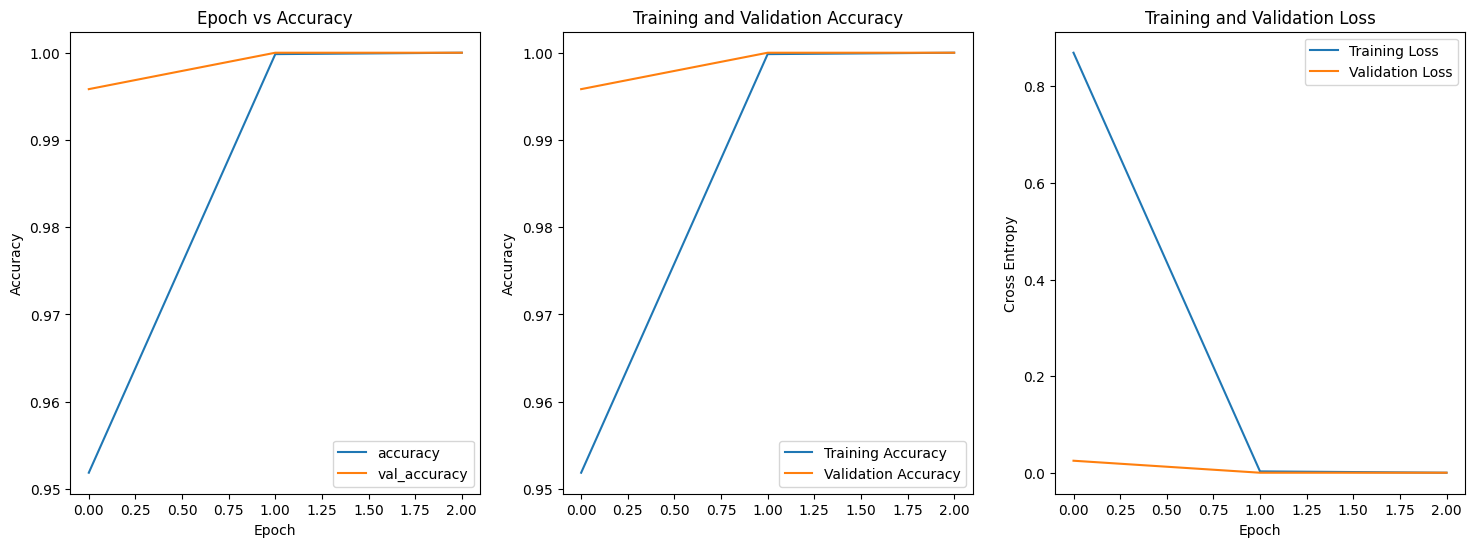

In [ ]:
plot_hist_graph(hist_1)

In [ ]:
from keras.applications import EfficientNetB0



effnet_model = EfficientNetB0()
effnet_model.trainable = False


In [ ]:
x = Flatten()(effnet_model.output)
o = Dense(len(class_names), activation="softmax", name="output_layer")(x)

model_2 = keras.Model(effnet_model.input,o , name = "RESNET_MODEL")
model_2.summary()

Model: "RESNET_MODEL"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 224, 224, 3)          0         ['input_11[0][0]']            
                                                                                                  
 normalization_1 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_1[0

In [ ]:
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
hist_2 = model_2.fit(train_ds,
                        epochs = 3,
                        steps_per_epoch = len(train_ds),
                        validation_data = val_ds,
                        validation_steps = len(val_ds),
                        callbacks = [model_checkpoint_callback('Model_1_EffcientNet'),early_stopping])

Epoch 1/3
195/195 [==============================] - 77s 350ms/step - loss: 3.1080 - accuracy: 0.1337 - val_loss: 3.0369 - val_accuracy: 0.2213
Epoch 2/3
195/195 [==============================] - 68s 347ms/step - loss: 2.9837 - accuracy: 0.2409 - val_loss: 2.9183 - val_accuracy: 0.3089
Epoch 3/3
195/195 [==============================] - 61s 312ms/step - loss: 2.8754 - accuracy: 0.3017 - val_loss: 2.8125 - val_accuracy: 0.3359


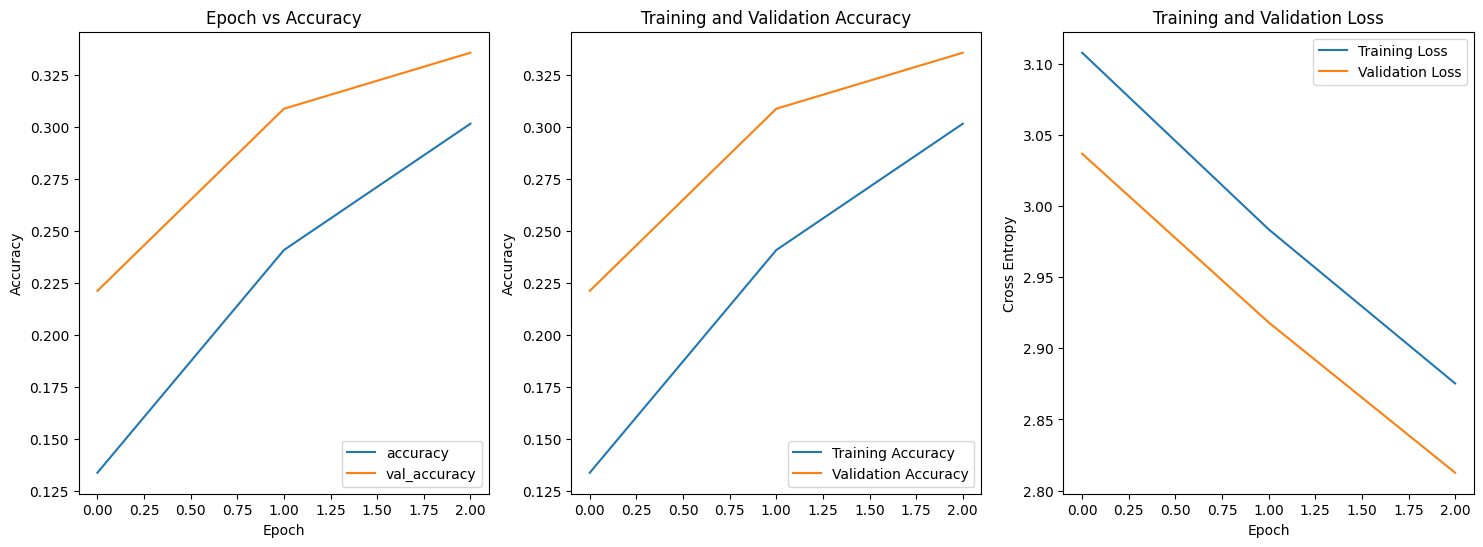

In [ ]:
plot_hist_graph(hist_2)